# Federated Learning + Linear Quantization for RESNET18 & CIFAR10

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import numpy as np
from tqdm import tqdm
import seaborn as sns
from fedlern.utils import *
from fedlern.train_utils import *
from fedlern.quant_utils import *
from fedlern.models.resnet_v2 import ResNet18

## Relevant Parameters

In [2]:
epoch = 6
rounds = 40#25
num_clients = 10

clients_sample_size = int(.5 * num_clients) # Use 30% of available clients
num_workers = 8
train_batch_size = 32 #128
eval_batch_size= 32 #256
quantize_bits = 32
stats = (0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)

## Data Loaders
- Divide the test & training data
- Divide the training data among the clients

In [3]:
 # Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# Normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_test)

# split the training data
train_splits = torch.utils.data.random_split(train_dataset, [int(train_dataset.data.shape[0]/num_clients) for i in range(num_clients)])

# Data loaders
train_loaders = [DataLoader(dataset=split, batch_size=train_batch_size, shuffle=True, num_workers=num_workers) for split in train_splits]
test_loader = DataLoader(dataset=test_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=num_workers)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Files already downloaded and verified



- `server_aggregate` function aggregates the model weights received from every client and updates the global model with the updated weights.

In [4]:

def server_aggregate(global_model : torch.nn.Module, client_models):
    """
    The means of the weights of the client models are aggregated to the global model
    """
    global_dict = global_model.state_dict() # Get a copy of the global model state_dict
    for key in global_dict.keys():
        global_dict[key] = torch.stack([client_models[i].state_dict()[key].float() for i in range(len(client_models))],0).mean(0)
    global_model.load_state_dict(global_dict)
    
    # Update the client models using the global model
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

## Global & Clients instatiation
Implement the same elements as before, but:
- We need more instances of the model
- An optimizer for each model

In [5]:
global_model = ResNet18().to(device)
client_models = [ResNet18()
                     .to(device)
                     #.load_state_dict(global_model.state_dict())
                  for _ in range(num_clients)]


In [6]:
# Optimizer & criterion based on gobal model
global_optimizer = get_model_optimizer(global_model,
                                       learning_rate=0.1,
                                       weight_decay=5e-4)

#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80,120,160], gamma=0.1)
criterion = nn.CrossEntropyLoss().to(device) # computes the cross-entropy loss between the predicted and true labels

optimizers = [get_model_optimizer(model,learning_rate=0.1, weight_decay=5e-4) for model in client_models]

optimizers_quant = [get_model_optimizer(model,learning_rate=0.1, weight_decay=5e-4) for model in client_models]


In [7]:
# initialize lists to store the training and testing losses and accuracies
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for round in tqdm(range(rounds)):


    # Select n random clients
    selected_clients = np.random.permutation(num_clients)[:clients_sample_size]
    # Train the selected clients
    for client in selected_clients:
        # Individual criterion and optimizer

        train_loss, train_acc = qtrain_model(model = client_models[client],
                                             train_loader = train_loaders[client],
                                             device = device,
                                             criterion = criterion,
                                             optimizer = optimizers[client],
                                             num_epochs=epoch,
                                             bits = quantize_bits)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Aggregate
    server_aggregate(global_model, client_models)

    # Test the global model
    test_loss, test_acc = evaluate_model(model=global_model,
                                         test_loader=test_loader,
                                         device=device,
                                         criterion=criterion)

    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f"{round}-th ROUND: average train loss {(train_loss / clients_sample_size):0.3g} | test loss {test_loss:0.3g} | test acc: {test_acc:0.3f}")
    
    

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0/6 Train Loss: 3.088 Train Acc: 0.161
Epoch: 1/6 Train Loss: 2.139 Train Acc: 0.193
Epoch: 2/6 Train Loss: 2.136 Train Acc: 0.196
Epoch: 3/6 Train Loss: 2.135 Train Acc: 0.201
Epoch: 4/6 Train Loss: 2.135 Train Acc: 0.194
Epoch: 5/6 Train Loss: 2.126 Train Acc: 0.198
Epoch: 0/6 Train Loss: 2.907 Train Acc: 0.136
Epoch: 1/6 Train Loss: 2.232 Train Acc: 0.169
Epoch: 2/6 Train Loss: 2.228 Train Acc: 0.162
Epoch: 3/6 Train Loss: 2.230 Train Acc: 0.164
Epoch: 4/6 Train Loss: 2.219 Train Acc: 0.170
Epoch: 5/6 Train Loss: 2.226 Train Acc: 0.169
Epoch: 0/6 Train Loss: 2.806 Train Acc: 0.137
Epoch: 1/6 Train Loss: 2.191 Train Acc: 0.169
Epoch: 2/6 Train Loss: 2.188 Train Acc: 0.165
Epoch: 3/6 Train Loss: 2.188 Train Acc: 0.164
Epoch: 4/6 Train Loss: 2.193 Train Acc: 0.169
Epoch: 5/6 Train Loss: 2.187 Train Acc: 0.174
Epoch: 0/6 Train Loss: 2.516 Train Acc: 0.175
Epoch: 1/6 Train Loss: 2.052 Train Acc: 0.204
Epoch: 2/6 Train Loss: 2.059 Train Acc: 0.202
Epoch: 3/6 Train Loss: 2.046 Train

  2%|▎         | 1/40 [06:06<3:58:20, 366.68s/it]

0-th ROUND: average train loss 0.435 | test loss 2.3 | test acc: 0.100
Epoch: 0/6 Train Loss: 2.126 Train Acc: 0.176
Epoch: 1/6 Train Loss: 1.991 Train Acc: 0.215
Epoch: 2/6 Train Loss: 1.982 Train Acc: 0.230
Epoch: 3/6 Train Loss: 1.991 Train Acc: 0.227
Epoch: 4/6 Train Loss: 1.986 Train Acc: 0.227
Epoch: 5/6 Train Loss: 1.983 Train Acc: 0.228
Epoch: 0/6 Train Loss: 2.450 Train Acc: 0.102
Epoch: 1/6 Train Loss: 2.427 Train Acc: 0.108
Epoch: 2/6 Train Loss: 2.421 Train Acc: 0.097
Epoch: 3/6 Train Loss: 2.419 Train Acc: 0.101
Epoch: 4/6 Train Loss: 2.421 Train Acc: 0.102
Epoch: 5/6 Train Loss: 2.413 Train Acc: 0.107
Epoch: 0/6 Train Loss: 2.464 Train Acc: 0.108
Epoch: 1/6 Train Loss: 2.423 Train Acc: 0.109
Epoch: 2/6 Train Loss: 2.420 Train Acc: 0.113
Epoch: 3/6 Train Loss: 2.421 Train Acc: 0.111
Epoch: 4/6 Train Loss: 2.418 Train Acc: 0.110
Epoch: 5/6 Train Loss: 2.426 Train Acc: 0.109
Epoch: 0/6 Train Loss: 2.148 Train Acc: 0.197
Epoch: 1/6 Train Loss: 2.025 Train Acc: 0.226
Epoch: 2/

  5%|▌         | 2/40 [12:32<3:59:31, 378.20s/it]

1-th ROUND: average train loss 0.406 | test loss 2.3 | test acc: 0.100
Epoch: 0/6 Train Loss: 2.190 Train Acc: 0.166
Epoch: 1/6 Train Loss: 2.189 Train Acc: 0.165
Epoch: 2/6 Train Loss: 2.189 Train Acc: 0.164
Epoch: 3/6 Train Loss: 2.189 Train Acc: 0.161
Epoch: 4/6 Train Loss: 2.194 Train Acc: 0.167
Epoch: 5/6 Train Loss: 2.190 Train Acc: 0.164
Epoch: 0/6 Train Loss: 2.159 Train Acc: 0.172
Epoch: 1/6 Train Loss: 2.148 Train Acc: 0.180
Epoch: 2/6 Train Loss: 2.151 Train Acc: 0.177
Epoch: 3/6 Train Loss: 2.149 Train Acc: 0.180
Epoch: 4/6 Train Loss: 2.150 Train Acc: 0.176
Epoch: 5/6 Train Loss: 2.153 Train Acc: 0.175
Epoch: 0/6 Train Loss: 2.103 Train Acc: 0.204
Epoch: 1/6 Train Loss: 2.009 Train Acc: 0.224
Epoch: 2/6 Train Loss: 2.015 Train Acc: 0.232
Epoch: 3/6 Train Loss: 2.009 Train Acc: 0.230
Epoch: 4/6 Train Loss: 2.014 Train Acc: 0.225
Epoch: 5/6 Train Loss: 2.006 Train Acc: 0.232
Epoch: 0/6 Train Loss: 2.162 Train Acc: 0.171
Epoch: 1/6 Train Loss: 2.150 Train Acc: 0.176
Epoch: 2/

  8%|▊         | 3/40 [18:58<3:55:22, 381.69s/it]

2-th ROUND: average train loss 0.43 | test loss 2.31 | test acc: 0.100
Epoch: 0/6 Train Loss: 2.088 Train Acc: 0.200
Epoch: 1/6 Train Loss: 2.082 Train Acc: 0.203
Epoch: 2/6 Train Loss: 2.084 Train Acc: 0.202
Epoch: 3/6 Train Loss: 2.084 Train Acc: 0.204
Epoch: 4/6 Train Loss: 2.087 Train Acc: 0.205
Epoch: 5/6 Train Loss: 2.086 Train Acc: 0.206
Epoch: 0/6 Train Loss: 2.086 Train Acc: 0.212
Epoch: 1/6 Train Loss: 2.079 Train Acc: 0.211
Epoch: 2/6 Train Loss: 2.081 Train Acc: 0.206
Epoch: 3/6 Train Loss: 2.080 Train Acc: 0.212
Epoch: 4/6 Train Loss: 2.081 Train Acc: 0.208
Epoch: 5/6 Train Loss: 2.084 Train Acc: 0.213
Epoch: 0/6 Train Loss: 2.109 Train Acc: 0.201
Epoch: 1/6 Train Loss: 2.109 Train Acc: 0.214
Epoch: 2/6 Train Loss: 2.110 Train Acc: 0.203
Epoch: 3/6 Train Loss: 2.111 Train Acc: 0.200
Epoch: 4/6 Train Loss: 2.109 Train Acc: 0.208
Epoch: 5/6 Train Loss: 2.107 Train Acc: 0.213
Epoch: 0/6 Train Loss: 2.088 Train Acc: 0.213
Epoch: 1/6 Train Loss: 2.077 Train Acc: 0.213
Epoch: 2/

 10%|█         | 4/40 [25:25<3:50:07, 383.53s/it]

3-th ROUND: average train loss 0.419 | test loss 2.31 | test acc: 0.117
Epoch: 0/6 Train Loss: 2.097 Train Acc: 0.205
Epoch: 1/6 Train Loss: 2.099 Train Acc: 0.206
Epoch: 2/6 Train Loss: 2.097 Train Acc: 0.196
Epoch: 3/6 Train Loss: 2.098 Train Acc: 0.205
Epoch: 4/6 Train Loss: 2.099 Train Acc: 0.202
Epoch: 5/6 Train Loss: 2.097 Train Acc: 0.200
Epoch: 0/6 Train Loss: 2.110 Train Acc: 0.207
Epoch: 1/6 Train Loss: 2.102 Train Acc: 0.207
Epoch: 2/6 Train Loss: 2.101 Train Acc: 0.208
Epoch: 3/6 Train Loss: 2.100 Train Acc: 0.209
Epoch: 4/6 Train Loss: 2.105 Train Acc: 0.208
Epoch: 5/6 Train Loss: 2.101 Train Acc: 0.208
Epoch: 0/6 Train Loss: 2.097 Train Acc: 0.209
Epoch: 1/6 Train Loss: 2.098 Train Acc: 0.207
Epoch: 2/6 Train Loss: 2.101 Train Acc: 0.204
Epoch: 3/6 Train Loss: 2.095 Train Acc: 0.209
Epoch: 4/6 Train Loss: 2.096 Train Acc: 0.209
Epoch: 5/6 Train Loss: 2.099 Train Acc: 0.197
Epoch: 0/6 Train Loss: 2.092 Train Acc: 0.206
Epoch: 1/6 Train Loss: 2.092 Train Acc: 0.210
Epoch: 2

 12%|█▎        | 5/40 [31:51<3:44:18, 384.52s/it]

4-th ROUND: average train loss 0.403 | test loss 2.31 | test acc: 0.100
Epoch: 0/6 Train Loss: 2.076 Train Acc: 0.210
Epoch: 1/6 Train Loss: 2.069 Train Acc: 0.206
Epoch: 2/6 Train Loss: 2.078 Train Acc: 0.205
Epoch: 3/6 Train Loss: 2.073 Train Acc: 0.204
Epoch: 4/6 Train Loss: 2.076 Train Acc: 0.208
Epoch: 5/6 Train Loss: 2.074 Train Acc: 0.211
Epoch: 0/6 Train Loss: 2.076 Train Acc: 0.200
Epoch: 1/6 Train Loss: 2.076 Train Acc: 0.194
Epoch: 2/6 Train Loss: 2.076 Train Acc: 0.194
Epoch: 3/6 Train Loss: 2.078 Train Acc: 0.199
Epoch: 4/6 Train Loss: 2.074 Train Acc: 0.194
Epoch: 5/6 Train Loss: 2.075 Train Acc: 0.201
Epoch: 0/6 Train Loss: 2.086 Train Acc: 0.205
Epoch: 1/6 Train Loss: 2.086 Train Acc: 0.201
Epoch: 2/6 Train Loss: 2.085 Train Acc: 0.213
Epoch: 3/6 Train Loss: 2.083 Train Acc: 0.205
Epoch: 4/6 Train Loss: 2.086 Train Acc: 0.211
Epoch: 5/6 Train Loss: 2.083 Train Acc: 0.208
Epoch: 0/6 Train Loss: 2.060 Train Acc: 0.215
Epoch: 1/6 Train Loss: 2.050 Train Acc: 0.215
Epoch: 2

 15%|█▌        | 6/40 [38:17<3:38:09, 384.99s/it]

5-th ROUND: average train loss 0.414 | test loss 2.3 | test acc: 0.104
Epoch: 0/6 Train Loss: 2.076 Train Acc: 0.199
Epoch: 1/6 Train Loss: 2.074 Train Acc: 0.202
Epoch: 2/6 Train Loss: 2.073 Train Acc: 0.203
Epoch: 3/6 Train Loss: 2.074 Train Acc: 0.208
Epoch: 4/6 Train Loss: 2.076 Train Acc: 0.200
Epoch: 5/6 Train Loss: 2.073 Train Acc: 0.203
Epoch: 0/6 Train Loss: 2.072 Train Acc: 0.204
Epoch: 1/6 Train Loss: 2.073 Train Acc: 0.195
Epoch: 2/6 Train Loss: 2.071 Train Acc: 0.201
Epoch: 3/6 Train Loss: 2.073 Train Acc: 0.200
Epoch: 4/6 Train Loss: 2.075 Train Acc: 0.194
Epoch: 5/6 Train Loss: 2.074 Train Acc: 0.201
Epoch: 0/6 Train Loss: 2.074 Train Acc: 0.199
Epoch: 1/6 Train Loss: 2.077 Train Acc: 0.201
Epoch: 2/6 Train Loss: 2.075 Train Acc: 0.206
Epoch: 3/6 Train Loss: 2.072 Train Acc: 0.208
Epoch: 4/6 Train Loss: 2.075 Train Acc: 0.205
Epoch: 5/6 Train Loss: 2.073 Train Acc: 0.202
Epoch: 0/6 Train Loss: 2.074 Train Acc: 0.202
Epoch: 1/6 Train Loss: 2.076 Train Acc: 0.205
Epoch: 2/

 18%|█▊        | 7/40 [44:11<3:26:16, 375.04s/it]

6-th ROUND: average train loss 0.415 | test loss 2.25 | test acc: 0.134
Epoch: 0/6 Train Loss: 2.071 Train Acc: 0.200
Epoch: 1/6 Train Loss: 2.076 Train Acc: 0.195
Epoch: 2/6 Train Loss: 2.070 Train Acc: 0.194
Epoch: 3/6 Train Loss: 2.077 Train Acc: 0.194
Epoch: 4/6 Train Loss: 2.072 Train Acc: 0.197
Epoch: 5/6 Train Loss: 2.075 Train Acc: 0.198
Epoch: 0/6 Train Loss: 2.071 Train Acc: 0.202
Epoch: 1/6 Train Loss: 2.065 Train Acc: 0.207
Epoch: 2/6 Train Loss: 2.071 Train Acc: 0.204
Epoch: 3/6 Train Loss: 2.067 Train Acc: 0.207
Epoch: 4/6 Train Loss: 2.070 Train Acc: 0.206
Epoch: 5/6 Train Loss: 2.072 Train Acc: 0.207
Epoch: 0/6 Train Loss: 2.081 Train Acc: 0.210
Epoch: 1/6 Train Loss: 2.083 Train Acc: 0.209
Epoch: 2/6 Train Loss: 2.080 Train Acc: 0.207
Epoch: 3/6 Train Loss: 2.085 Train Acc: 0.207
Epoch: 4/6 Train Loss: 2.083 Train Acc: 0.208
Epoch: 5/6 Train Loss: 2.083 Train Acc: 0.209
Epoch: 0/6 Train Loss: 2.079 Train Acc: 0.200
Epoch: 1/6 Train Loss: 2.078 Train Acc: 0.200
Epoch: 2

 20%|██        | 8/40 [49:42<3:12:26, 360.84s/it]

7-th ROUND: average train loss 0.414 | test loss 2.16 | test acc: 0.187
Epoch: 0/6 Train Loss: 2.074 Train Acc: 0.203
Epoch: 1/6 Train Loss: 2.078 Train Acc: 0.197
Epoch: 2/6 Train Loss: 2.079 Train Acc: 0.210
Epoch: 3/6 Train Loss: 2.071 Train Acc: 0.201
Epoch: 4/6 Train Loss: 2.078 Train Acc: 0.200
Epoch: 5/6 Train Loss: 2.071 Train Acc: 0.208
Epoch: 0/6 Train Loss: 2.087 Train Acc: 0.196
Epoch: 1/6 Train Loss: 2.083 Train Acc: 0.202
Epoch: 2/6 Train Loss: 2.082 Train Acc: 0.195
Epoch: 3/6 Train Loss: 2.081 Train Acc: 0.199
Epoch: 4/6 Train Loss: 2.080 Train Acc: 0.201
Epoch: 5/6 Train Loss: 2.090 Train Acc: 0.192
Epoch: 0/6 Train Loss: 2.073 Train Acc: 0.211
Epoch: 1/6 Train Loss: 2.068 Train Acc: 0.211
Epoch: 2/6 Train Loss: 2.065 Train Acc: 0.205
Epoch: 3/6 Train Loss: 2.066 Train Acc: 0.210
Epoch: 4/6 Train Loss: 2.075 Train Acc: 0.202
Epoch: 5/6 Train Loss: 2.070 Train Acc: 0.207
Epoch: 0/6 Train Loss: 2.078 Train Acc: 0.200
Epoch: 1/6 Train Loss: 2.075 Train Acc: 0.188
Epoch: 2

 22%|██▎       | 9/40 [55:12<3:01:33, 351.39s/it]

8-th ROUND: average train loss 0.415 | test loss 2.1 | test acc: 0.209
Epoch: 0/6 Train Loss: 2.071 Train Acc: 0.211
Epoch: 1/6 Train Loss: 2.066 Train Acc: 0.214
Epoch: 2/6 Train Loss: 2.069 Train Acc: 0.212
Epoch: 3/6 Train Loss: 2.065 Train Acc: 0.214
Epoch: 4/6 Train Loss: 2.071 Train Acc: 0.212
Epoch: 5/6 Train Loss: 2.066 Train Acc: 0.212
Epoch: 0/6 Train Loss: 2.073 Train Acc: 0.207
Epoch: 1/6 Train Loss: 2.072 Train Acc: 0.208
Epoch: 2/6 Train Loss: 2.069 Train Acc: 0.207
Epoch: 3/6 Train Loss: 2.070 Train Acc: 0.205
Epoch: 4/6 Train Loss: 2.067 Train Acc: 0.212
Epoch: 5/6 Train Loss: 2.070 Train Acc: 0.205
Epoch: 0/6 Train Loss: 2.088 Train Acc: 0.198
Epoch: 1/6 Train Loss: 2.083 Train Acc: 0.193
Epoch: 2/6 Train Loss: 2.082 Train Acc: 0.198
Epoch: 3/6 Train Loss: 2.086 Train Acc: 0.203
Epoch: 4/6 Train Loss: 2.083 Train Acc: 0.198
Epoch: 5/6 Train Loss: 2.084 Train Acc: 0.194
Epoch: 0/6 Train Loss: 2.072 Train Acc: 0.202
Epoch: 1/6 Train Loss: 2.077 Train Acc: 0.207
Epoch: 2/

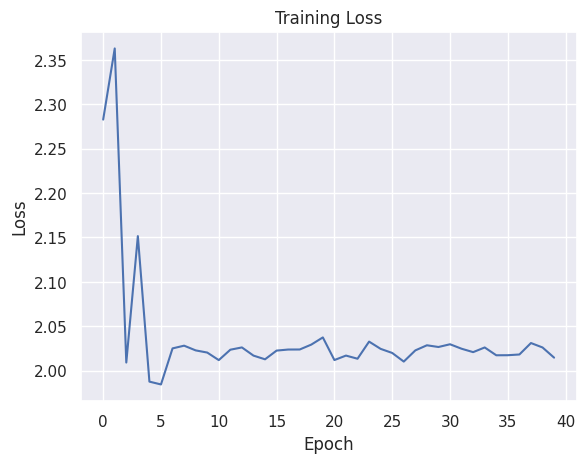

In [ ]:
# plot the training loss
sns.set(style='darkgrid')
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
train_accs = [d.item() for d in train_accs]
test_accs = [d.item() for d in test_accs]

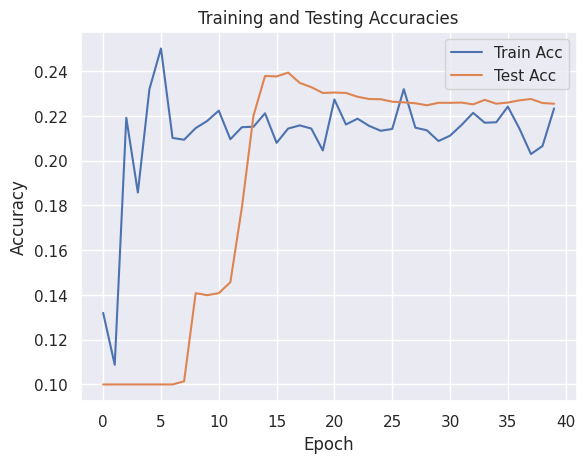

In [ ]:
# plot the training and testing accuracies
sns.set(style='darkgrid')
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Training and Testing Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
cuda_device = torch.device("cuda:0")
cpu_device = torch.device("cpu:0")
# Test the model
loss, acc = evaluate_model(global_model, test_loader, device,)
print(f'Loss: {loss}, Accuracy: {acc*100}%')
print_model_size(global_model)

# Measure inference latency
cpu_inference_latency = measure_inference_latency(model=global_model, device=cpu_device, input_size=(1,3,32,32), num_samples=100)
gpu_inference_latency = measure_inference_latency(model=global_model, device=cuda_device, input_size=(1,3,32,32), num_samples=100)
print("CPU Inference Latency: {:.2f} ms / sample".format(cpu_inference_latency * 1000))
print("CUDA Inference Latency: {:.2f} ms / sample".format(gpu_inference_latency * 1000))

Loss: 0.0, Accuracy: 22.549999237060547%
44.77 MB
CPU Inference Latency: 7.95 ms / sample
CUDA Inference Latency: 2.94 ms / sample


In [ ]:
save_model(global_model, "saved_models", f'resnet_fedlern_{quantize_bits}bits_{time_stamp()}.pth')

In [ ]:
pass